Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm
import random

dataset Pre-processing

In [2]:
dataset_path = '/content/drive/MyDrive/CVPR/animals'

In [3]:
# Initialize lists to store images and their corresponding labels
images = []
labels = []

# Loop through each animal folder in the dataset directory
for animal in os.listdir(dataset_path):
  labels.append(animal)    #add with label list
  animal_path = os.path.join(dataset_path, animal)

  print(f"Processing folder: {animal}")
  # Loop through each image file in the current animal's folder
  for img_filename in tqdm.tqdm(os.listdir(animal_path)):
    img_path = os.path.join(animal_path, img_filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (200, 200))
    images.append([img, labels.index(animal)])

Processing folder: dogs


100%|██████████| 1000/1000 [00:16<00:00, 60.00it/s]


Processing folder: cats


100%|██████████| 1000/1000 [00:09<00:00, 100.94it/s]


Processing folder: panda


100%|██████████| 1000/1000 [00:13<00:00, 72.68it/s]


In [4]:
len(images)

3000

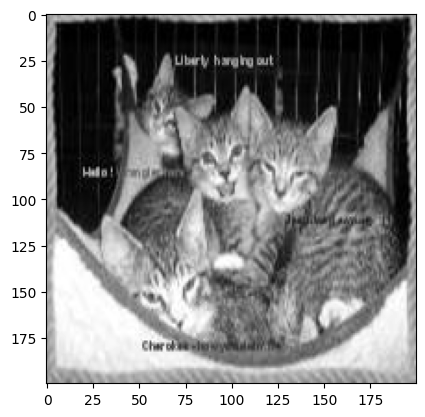

In [5]:
# Display a sample image from the dataset
image_data, label = images[1012] # Access image
plt.imshow(image_data, cmap='gray')
plt.show()

In [6]:
random.shuffle(images)

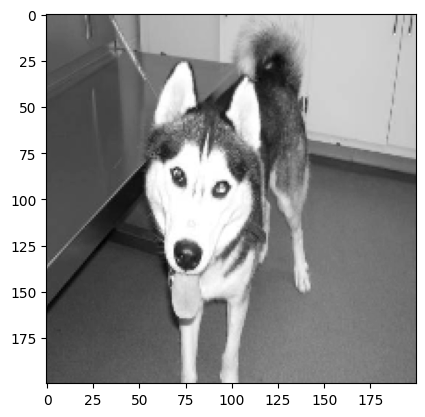

In [7]:
image_data, label = images[1012]
plt.imshow(image_data, cmap='gray')
plt.show()

In [8]:
# Function to create K-folds from the dataset
def create_folds(images, fold_value):
  fold_size = len(images) // fold_value  # Calculate the size of each fold
   # Split the images into K-folds
  folds = [images[i * fold_size: (i+1) * fold_size] for i in range(fold_value)]
  return folds

folds = create_folds(images, 5) # create 5 folds

In [9]:
#training set
train_set = []
for i in range(4):
  train_set += folds[i]
#test set
test_set = folds[4]

In [10]:
#total size of training and test set
print("Length of train set:", len(train_set))
print("Length of test set:", len(test_set))


Length of train set: 2400
Length of test set: 600


Model evaluation

In [11]:
#calculate L1 and L2 distances
def calculate_distances(train_set, test_set):
   # Initialize lists to store the distances for each test image
  l1_distances = []
  l2_distances = []

  for test_img in tqdm.tqdm(test_set):
    l1_for_one_img = []
    l2_for_one_img = []
    for train_img in train_set:
      l1 = np.sum(np.abs(test_img[0] - train_img[0]))
      l2 = np.sqrt(np.sum((test_img[0] - train_img[0]) ** 2))
      l1_for_one_img.append([l1, train_img[1]])
      l2_for_one_img.append([l2, train_img[1]])

    l1_distances.append(l1_for_one_img)
    l2_distances.append(l2_for_one_img)

  return l1_distances, l2_distances

l1_distances, l2_distances = calculate_distances(train_set, test_set)

100%|██████████| 600/600 [01:52<00:00,  5.32it/s]


In [12]:
# Function to calculate accuracy using K-nearest neighbors (KNN)

def calculate_accuracy(distances, k_neighbors, test_set, num_folds):
  accuracies = [[] for _ in range(k_neighbors)]

  for k in range(1, k_neighbors + 1):
     # Perform cross-validation over the specified number of folds
    for fold in range(num_folds):
      start = fold * (len(test_set) // num_folds)
      end = (fold + 1) * (len(test_set) // num_folds)
      fold_test_set = test_set[start:end]
      correct = 0
      for i, test_img in enumerate(fold_test_set):
            # Sort the distances and get the top k nearest neighbors
        neighbors = sorted(distances[start + i], key=lambda x: x[0])[:k]
        predicted_label = max(set([n[1] for n in neighbors]), key=[n[1] for n in neighbors].count)
        if predicted_label == test_img[1]:
          correct += 1
      accuracies[k-1].append(correct / len(fold_test_set))

  return accuracies


k_neighbors = 5
num_folds = 5
accuracy_l1 = calculate_accuracy(l1_distances, k_neighbors, test_set, num_folds)
accuracy_l2 = calculate_accuracy(l2_distances, k_neighbors, test_set, num_folds)



In [13]:
print("Accuracy (L1) for each k and fold:")
for i, accuracies_for_k in enumerate(accuracy_l1):
  print(f"k = {i+1}: {accuracies_for_k}")

print("\nAccuracy (L2) for each k and fold:")
for i, accuracies_for_k in enumerate(accuracy_l2):
  print(f"k = {i+1}: {accuracies_for_k}")

Accuracy (L1) for each k and fold:
k = 1: [0.375, 0.38333333333333336, 0.4166666666666667, 0.35833333333333334, 0.39166666666666666]
k = 2: [0.3416666666666667, 0.30833333333333335, 0.36666666666666664, 0.2833333333333333, 0.325]
k = 3: [0.35, 0.3333333333333333, 0.35, 0.4083333333333333, 0.43333333333333335]
k = 4: [0.375, 0.2833333333333333, 0.35, 0.38333333333333336, 0.4083333333333333]
k = 5: [0.3333333333333333, 0.325, 0.3333333333333333, 0.3416666666666667, 0.4083333333333333]

Accuracy (L2) for each k and fold:
k = 1: [0.43333333333333335, 0.375, 0.4, 0.4, 0.38333333333333336]
k = 2: [0.35833333333333334, 0.35, 0.31666666666666665, 0.38333333333333336, 0.39166666666666666]
k = 3: [0.4666666666666667, 0.45, 0.44166666666666665, 0.39166666666666666, 0.39166666666666666]
k = 4: [0.425, 0.4166666666666667, 0.36666666666666664, 0.4, 0.425]
k = 5: [0.475, 0.45, 0.4, 0.39166666666666666, 0.425]


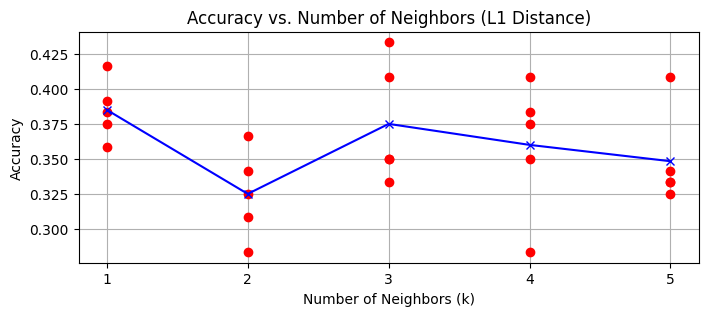

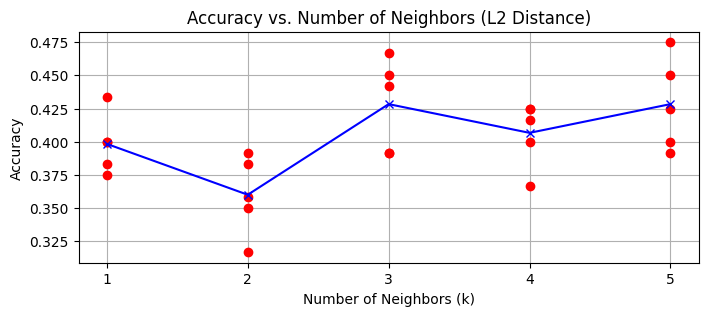

In [14]:
k_neighbors = 5
k_values = range(1, k_neighbors + 1)


# Plot for L1 distance
plt.figure(figsize=(8, 3))
 # Calculate mean across folds for each k
plt.plot(k_values, accuracy_l1, marker='o', linestyle='', color='r')
mean_accuracy_l1 = np.mean(accuracy_l1, axis=1)
plt.plot(k_values, mean_accuracy_l1, marker='x', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (L1 Distance)')
plt.xticks(k_values)

plt.grid(True)
plt.show()

# Plot for L2 distance
plt.figure(figsize=(8, 3))
 # Calculate mean across folds for each k
plt.plot(k_values, accuracy_l2, marker='o', linestyle='', color='r')
mean_accuracy_l2 = np.mean(accuracy_l2, axis=1)
plt.plot(k_values, mean_accuracy_l2, marker='x', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (L2 Distance)')
plt.xticks(k_values)

plt.grid(True)
plt.show()



<h3>Model Prediction

<h4>L1 distance prediction

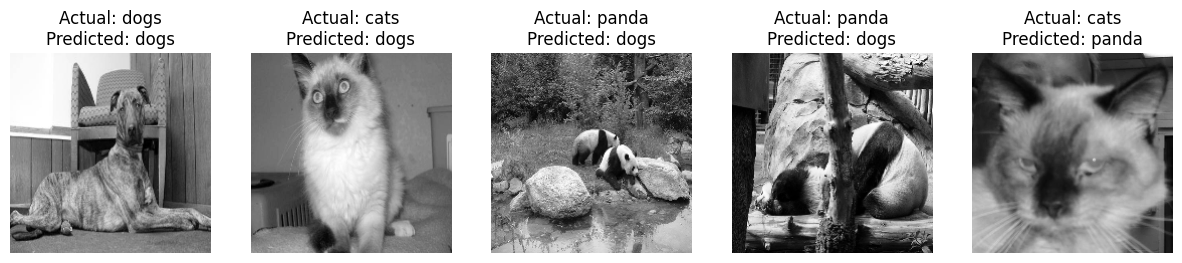

Accuracy: 20.00%


In [17]:
def predict_and_display_random(distances, test_set, labels, num_images=5, k_neighbors=5):
    random_indices = random.sample(range(len(test_set)), num_images)
    correct_predictions = 0

    # Create a figure for subplots with appropriate size
    plt.figure(figsize=(15, 3))  # Adjust the width and height accordingly

    for idx, i in enumerate(random_indices):
        test_image = test_set[i]

        # Get the distances for the current test image
        current_distances = distances[i]

        # Sort based on distance and select top k
        top_k_neighbors = sorted(current_distances, key=lambda x: x[0])[:k_neighbors]

        # Perform majority voting among the top k neighbors
        predicted_label = max(set([n[1] for n in top_k_neighbors]), key=[n[1] for n in top_k_neighbors].count)

        # Check if prediction is correct
        if predicted_label == test_image[1]:
            correct_predictions += 1

        # Plot the image in the ith subplot
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(test_image[0], cmap='gray')

        plt.title(f"Actual: {labels[test_image[1]]}\nPredicted: {labels[predicted_label]}")
        plt.axis('off')  # Hide the axes for a cleaner look

    # Display all images together
    plt.show()

    # Calculate and print accuracy
    accuracy = (correct_predictions / num_images) * 100
    print(f'Accuracy: {accuracy:.2f}%')

# Assuming distances are calculated for the test set
predict_and_display_random(l1_distances, test_set, labels)


<h4> L2 distance prediction

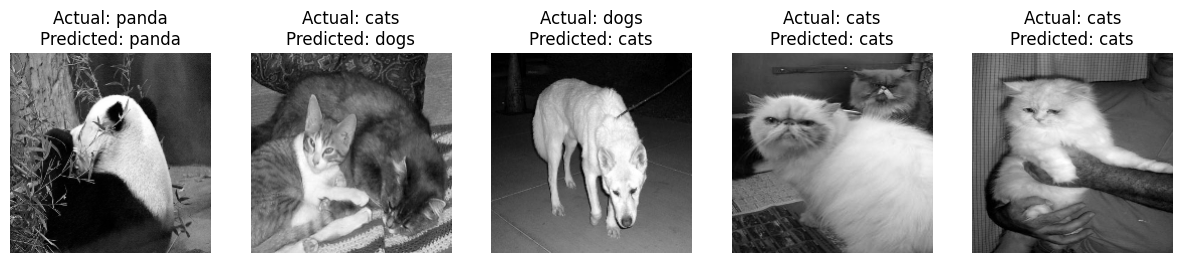

Accuracy: 60.00%


In [18]:
def predict_and_display_random(distances, test_set, labels, num_images=5, k_neighbors=5):
    random_indices = random.sample(range(len(test_set)), num_images)
    correct_predictions = 0

    # Create a figure for subplots with appropriate size
    plt.figure(figsize=(15, 3))  # Adjust the width and height accordingly

    for idx, i in enumerate(random_indices):
        test_image = test_set[i]

        # Get the distances for the current test image
        current_distances = distances[i]

        # Sort based on distance and select top k
        top_k_neighbors = sorted(current_distances, key=lambda x: x[0])[:k_neighbors]

        # Perform majority voting among the top k neighbors
        predicted_label = max(set([n[1] for n in top_k_neighbors]), key=[n[1] for n in top_k_neighbors].count)

        # Check if prediction is correct
        if predicted_label == test_image[1]:
            correct_predictions += 1

        # Plot the image in the ith subplot
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(test_image[0], cmap='gray')
        plt.title(f"Actual: {labels[test_image[1]]}\nPredicted: {labels[predicted_label]}")
        plt.axis('off')  # Hide the axes for a cleaner look

    # Display all images together
    plt.show()

    # Calculate and print accuracy
    accuracy = (correct_predictions / num_images) * 100
    print(f'Accuracy: {accuracy:.2f}%')

# Assuming distances are calculated for the test set
predict_and_display_random(l2_distances, test_set, labels)


<h1>Discussion

---



<h2> Comparison and Implications:

<h5>
*   L1 distance shows a notable improvement as k increases, particularly at
k=5, suggesting that it may be better suited for this dataset when more neighbors are considered.
*  L2 distance has a slight edge for middle values of k but doesn't outperform L1 consistently.

However, Looking at the plots, L2 (Euclidean) distance shows a more consistent and generally higher accuracy across different values of
𝑘
k compared to L1 (Manhattan) distance. The L2 distance plot has higher peaks and less fluctuation in accuracy, which suggests that it might be more reliable for this specific dataset and classification task. Overall, L2 appears to provide better performance
<h5>


<h2>Dataset's characteristics :<h4>

grayscale images with a resolution of 32x32—the nature of the features seems to favor the Euclidean distance for this specific classification task. However, the differences in accuracy between L1 and L2 are not substantial, indicating that both metrics are viable options, with L2 having a slight edge in this context.

<h2> Limitations : <h2>



1.  Grayscale images may miss important color information that could enhance classification.
2.   The k-NN algorithm might not capture complex patterns; more advanced models could be explored.
3.   The findings are specific to this dataset; different datasets and preprocessing could yield better results

